In [ ]:
# Name: Kishan Kumar Sachdeva
# Email: ksachdev@ucsd.edu
# PID: A53104678
from pyspark import SparkContext
sc = SparkContext()

In [1]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils

### Higgs data set
* **URL:** http://archive.ics.uci.edu/ml/datasets/HIGGS#  
* **Abstract:** This is a classification problem to distinguish between a signal process which produces Higgs bosons and a background process which does not.

**Data Set Information:**  
The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set.



In [3]:
# #define feature names
# feature_text='lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'
# features=[strip(a) for a in split(feature_text,',')]
# # print len(features),features

In [1]:
# # create a directory called higgs, download and decompress HIGGS.csv.gz into it

# from os.path import exists
# if not exists('higgs'):
#     print "creating directory higgs"
#     !mkdir higgs
# %cd higgs
# if not exists('HIGGS.csv'):
#     if not exists('HIGGS.csv.gz'):
#         print 'downloading HIGGS.csv.gz'
#         !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
#     print 'decompressing HIGGS.csv.gz --- May take 5-10 minutes'
#     !gunzip -f HIGGS.csv.gz
# !ls -l
# %cd ..

/home/shire/Dropbox/CSE255/Kishan_Jupyter/HW/HW-5/higgs
downloading HIGGS.csv.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2685M  100 2685M    0     0  15.8M      0  0:02:49  0:02:49 --:--:-- 43.7M
decompressing HIGGS.csv.gz --- May take 5-10 minutes

gzip: HIGGS.csv: No space left on device
total 2750408
-rw-rw-r-- 1 shire shire 2816407858 May 24 18:36 HIGGS.csv.gz
/home/shire/Dropbox/CSE255/Kishan_Jupyter/HW/HW-5


### As done in previous notebook, create RDDs from raw data and build Gradient boosting and Random forests models. Consider doing 1% sampling since the dataset is too big for your local machine

In [9]:
# Import data, sample and create labeledPoints
path='/higgs/HIGGS.csv'
# cluster
#path='/HIGGS/HIGGS.csv'
inputRDD=sc.textFile(path).sample(False,0.01,seed=255).cache()
Data=inputRDD.map(lambda x:x.split(','))\
            .map(lambda x:LabeledPoint(x[0],x[1:])).cache()



In [10]:
# create a train and test data split
(trainingData,testData)=Data.randomSplit([0.7,0.3],seed=255)
# counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
# counts.sort(key=lambda x:x[1],reverse=True)
# counts

In [11]:
trainingData=trainingData.cache()
testData=testData.cache()

In [18]:
print 'Gradient Boosted Trees'
from time import time
errors={}
for depth in [1,3,6,10]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(trainingData,
                                             categoricalFeaturesInfo={}, numIterations=35,learningRate=0.15,
                                               maxDepth=depth)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    #print 'training completed for ', depth
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
B10 = errors

Gradient Boosted Trees
1 {'test': 0.34088221919054118, 'train': 0.33800438966739826} 33 seconds
3 {'test': 0.29628619069273915, 'train': 0.28995181755607213} 21 seconds
6 {'test': 0.28024859784750644, 'train': 0.24808114391095989} 34 seconds
10 {'test': 0.29640745793542517, 'train': 0.086793334978376338} 136 seconds


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


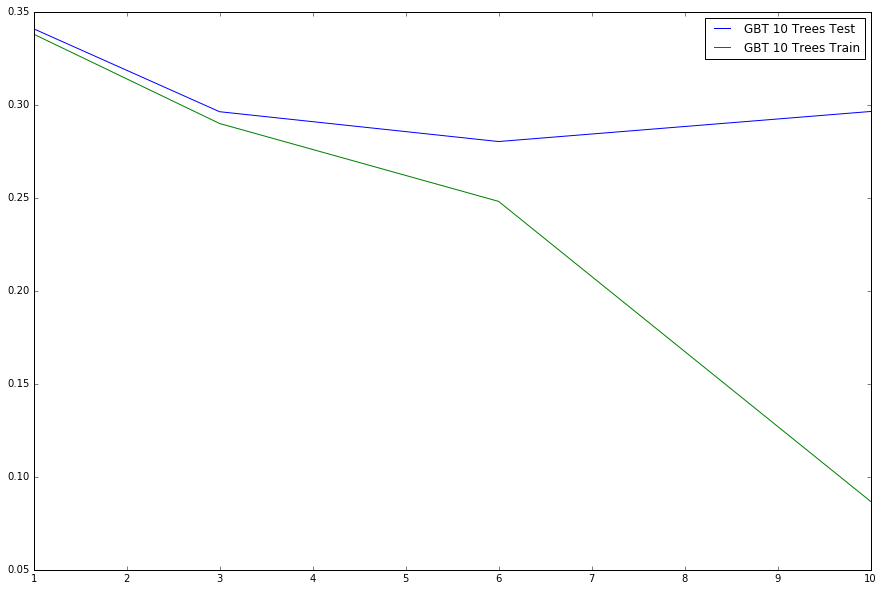

In [21]:
B10_keys=[]
B10_train=[]
B10_test=[]
for pt in sorted(B10.keys()):
    B10_keys.append(pt)
    B10_test.append(B10[pt]['test'])
    B10_train.append(B10[pt]['train'])
    
%pylab inline
figure(figsize=(15,10))
plot(B10_keys,B10_test,label='GBT 10 Trees Test')
plot(B10_keys,B10_train,label='GBT 10 Trees Train')

pylab.legend()

In [22]:
from pyspark.mllib.tree import RandomForest
#from time import time
print 'Random Forest'
errors={}
for depth in [1,3,6,10]:
    start=time()
    model = RandomForest.trainClassifier(trainingData, numClasses=7, categoricalFeaturesInfo={},
                                     numTrees=8, featureSubsetStrategy="auto",
                                     impurity='entropy', maxDepth=depth, maxBins=32)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
RF_10trees= errors

Random Forest
1 {'test': 0.4422228308834718, 'train': 0.4391797057753288} 279 seconds
3 {'test': 0.38029154873854953, 'train': 0.3744346831626553} 241 seconds
6 {'test': 0.33625490733132474, 'train': 0.3265841867235016} 447 seconds
10 {'test': 0.30652180528926626, 'train': 0.27137807350418464} 747 seconds


Populating the interactive namespace from numpy and matplotlib


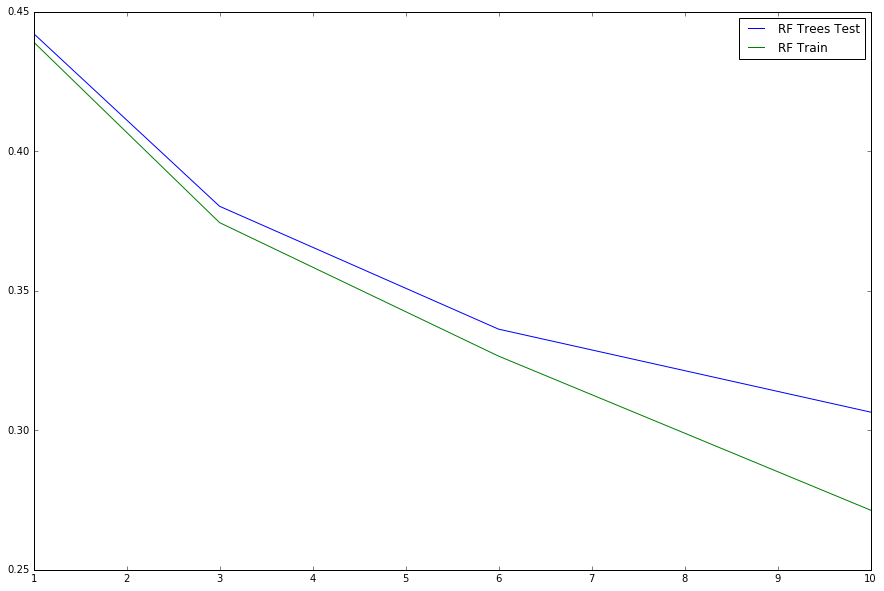

In [23]:
RF10_keys=[]
RF10_train=[]
RF10_test=[]
for pt in sorted(RF_10trees.keys()):
    RF10_keys.append(pt)
    RF10_test.append(RF_10trees[pt]['test'])
    RF10_train.append(RF_10trees[pt]['train'])
    
    
%pylab inline
figure(figsize=(15,10))
plot(RF10_keys,RF10_test,label='RF Trees Test')
plot(RF10_keys,RF10_train,label='RF Train')

pylab.legend()

# Plotting Gradient Boosting and Random Forest together 

Populating the interactive namespace from numpy and matplotlib


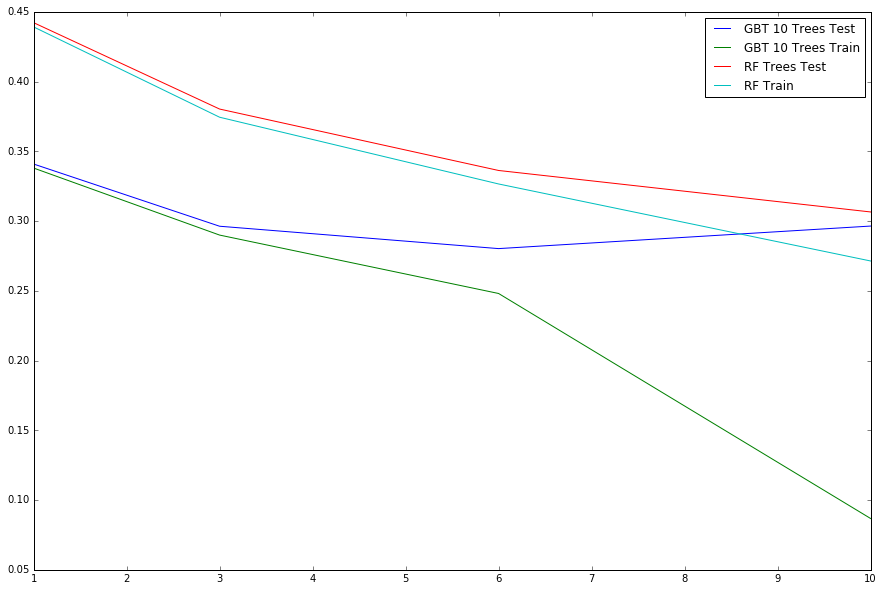

In [24]:
   
%pylab inline
figure(figsize=(15,10))
plot(B10_keys,B10_test,label='GBT 10 Trees Test')
plot(B10_keys,B10_train,label='GBT 10 Trees Train')
plot(RF10_keys,RF10_test,label='RF Trees Test')
plot(RF10_keys,RF10_train,label='RF Train')

pylab.legend()